In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pathpy as pp
import seaborn as sns
from typing import Callable
import random

### 1. Scale-Free Networks

#### a)


The following code generates a scale free network with $n = 1000$ nodes and $\gamma = 2.5$. 

In [33]:
gamma = 2.5
n = 1000
degrees = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees):
    degrees = np.random.zipf(a=gamma,size=n).astype(int)
net = pp.generators.Molloy_Reed(degrees)

We now compute the empirical degree distribution $p$ as well as the cumulative distribution $p_c$ for $P(X > k)$.

In [47]:
p =  np.bincount(degrees) / n
p_c = 1 - np.cumsum(p)

In order to compare the empirical observation to our analytical finding, we define the $k$-th generalized harmonic number $H_k^{(\gamma)}$ and the zeta function $\zeta$.

In [48]:
def Hk(k: int, gamma: float) -> float:
    return sum([(i+1)**-gamma for i in range(k)])

In [49]:
def zeta(gamma: float) -> float:
    from scipy.special import zeta
    return zeta(gamma)

As derived on the solution, the analytical expression for the survival function is $1 - \frac{H_k^{(\gamma)}}{\zeta(\gamma)}$. We compute the probabilities for all degrees that we have observed in the microstate:

In [53]:
p_a = [1 - Hk((k),gamma)/zeta(gamma) for k in range(len(p_c))]

When plotting both curves in a loglog plot, we immediately see that they are approximately equal:

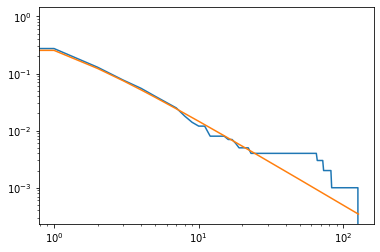

In [54]:
plt.loglog(p_c)
plt.loglog(p_a)

We observe a linear scaling behavior in the log-log plot which is characteristic for scale-invariant distributions.

#### b)

In [2]:
# General growth model that starts with a complete graph of m_0 nodes and successively adds nodes until it contains exactly n.
# Each new node has m edges that are assigned according to the growth function.
def growth_model(m_0: int, n: int, m: int, growth_function: Callable[[pp.Network, int, int],None]) -> pp.Network:
    import itertools
    assert m <= m_0
    assert n >= m_0

    # Create intial clique
    net = pp.Network(directed=False)
    net.add_nodes([f"i{i}" for i in range(m_0)])
    for (u,v) in itertools.combinations(net.nodes, 2):
        net.add_edge(u,v)
    
    # Grow the network to the desired size
    num_growth_steps = n - m_0
    for step in range(num_growth_steps):
       growth_function(net, m, step)
    
    return net




In [3]:
def grow_uniform(net: pp.Network, m: int,  step: int):
    neighborhood = np.random.choice(net.nodes, size=m, replace=False)
    new_node = pp.Node(f"g{step}")
    net.add_node(new_node)
    net.add_edges([pp.Edge(new_node, node) for node in neighborhood])

In [4]:
def grow_barabasi_albert(net: pp.Network, m: int, step: int):
    current_nodes = list(net.nodes)
    total_degree = net.number_of_edges() * 2
    probs = [net.degrees()[node.uid] / total_degree for node in current_nodes]
    neighborhood = np.random.choice(current_nodes, p=probs, size=m, replace=False)
    new_node = pp.Node(f"g{step}")
    net.add_node(new_node)
    net.add_edges([pp.Edge(new_node, node) for node in neighborhood])

In [5]:
def barabasi_albert(m_0: int, n: int, m: int) -> pp.Network:
    return growth_model(m_0, n, m, grow_barabasi_albert)

In [6]:
def uniform_growth(m_0: int, n: int, m: int) -> pp.Network:
    return growth_model(m_0, n, m, grow_uniform)

In [26]:
def plot_degree_dist(net: pp.Network):
    from collections import Counter
    cnt = Counter()
    for deg in net.degree_sequence():
        cnt[deg] += 1

    max_deg = int(max(net.degree_sequence()))
    xs = list(range(max_deg))
    ys = [cnt[k] for k in xs]
    plt.plot(xs, ys)

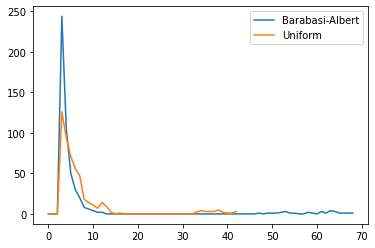

In [28]:
n = 500
m_0 = 30
m = 3
net_barabasi = barabasi_albert(m_0, n, m)
net_uniform = uniform_growth(m_0, n, m)

plot_degree_dist(net_barabasi)
plot_degree_dist(net_uniform)

plt.legend(["Barabasi-Albert", "Uniform"])

### 2. Limitations of Ensemble Studies

#### a)
The following code loads a network and computes the avg. clustering coefficient and degree assortativity over $n = 200$ Molloy-Reed microstates with the same degeree sequence.

In [62]:
moreno_taro = pp.io.konect.read_konect_name("moreno_taro")
moreno_train = pp.io.konect.read_konect_name("moreno_train")
dolphins = pp.io.konect.read_konect_name("dolphins")

[01-12 19:10:41: WARNING] KONECT data contains invalid timeiso: 1994/2001


In [63]:
def compare_with_molloy_reed(net: pp.Network, n: int):
    # Build microstates
    degrees = pp.statistics.degree_sequence(net)
    microstates = [pp.generators.Molloy_Reed(degrees) for _ in range(n)]

    # Compute metrics
    avg_clustering_coefficients = list(map(lambda n: pp.statistics.avg_clustering_coefficient(n), microstates))
    degree_assortativities = list(map(lambda n: pp.statistics.degree_assortativity(n), microstates))
    
    # Plot the results
    fig, axs = plt.subplots(ncols=2, figsize=(10,7))
    sns.histplot(avg_clustering_coefficients, ax=axs[0])
    sns.histplot(degree_assortativities, color="orange", ax=axs[1])
    fig.legend(["Avg. Clustering Coefficient", "Degree Assortativity"])

    # Compute averages
    print(f"Avg. Clustering Coefficient over all microstates: {np.mean(avg_clustering_coefficients).item()}")
    print(f"Avg. Degree Assortativity over all microstates: {np.mean(degree_assortativities).item()}")
    print(f"Network Avg. Clustering Coefficient: {pp.statistics.avg_clustering_coefficient(net)}")
    print(f"Network Degree Assortativity: {pp.statistics.degree_assortativity(net)}")


Avg. Clustering Coefficient over all microstates: 0.32795175783812147
Avg. Degree Assortativity over all microstates: -0.10096098265895907
Network Avg. Clustering Coefficient: 0.33939393939393936
Network Degree Assortativity: -6.518208092485515


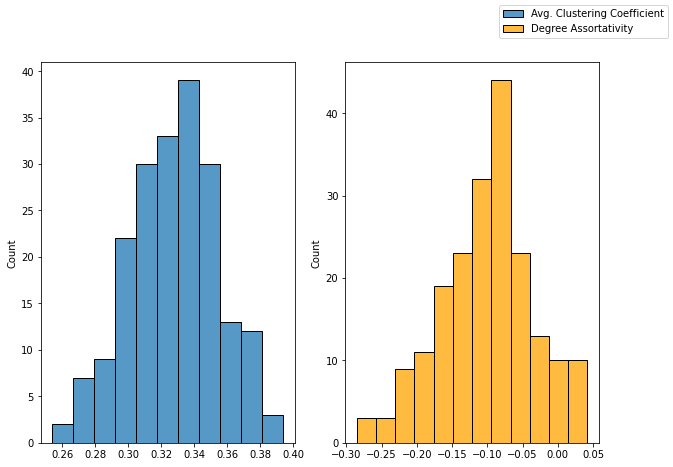

In [64]:
compare_with_molloy_reed(moreno_taro, 200)

For this network, the avg. clustering coefficient can easily be explained via the Molloy-Reed model. The degree assortativity, however, differs significantly from the empirical one. The cause for this difference is, therefore, unlikely to be rooted in the degrees of the original network.

Avg. Clustering Coefficient over all microstates: 0.27313891947310986
Avg. Degree Assortativity over all microstates: -0.14716389640390126
Network Avg. Clustering Coefficient: 0.6223250206309918
Network Degree Assortativity: 0.029464616495801618


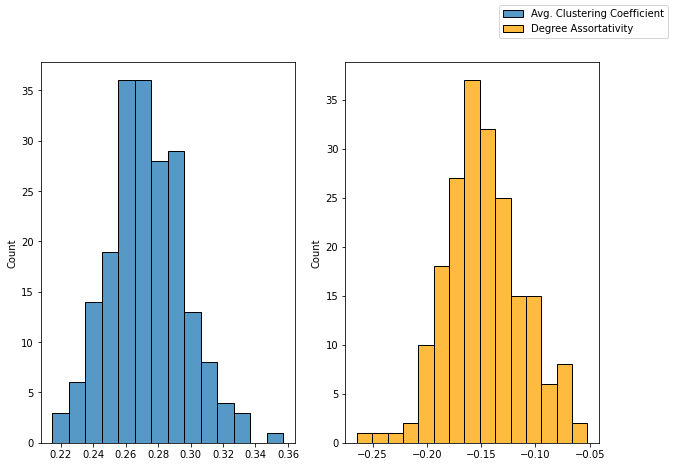

In [65]:
compare_with_molloy_reed(moreno_train, 200)

In this case, we can not derive any of the metrics from the Molly-Reed model.

Avg. Clustering Coefficient over all microstates: 0.0987119001070614
Avg. Degree Assortativity over all microstates: -0.04320202711957368
Network Avg. Clustering Coefficient: 0.2589582460550202
Network Degree Assortativity: -0.04359402821531415


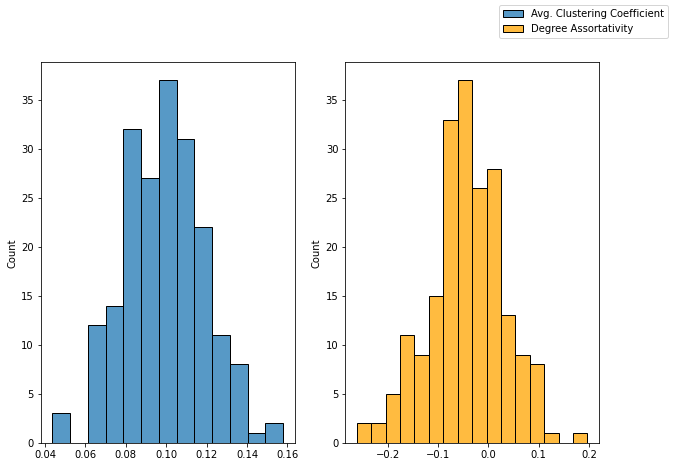

In [66]:
compare_with_molloy_reed(dolphins, 200)

Here, we can explain the degree assortativity via the Molloy-Reed microstates. The avg. clustering coefficient does, however, not match the predictions from random microstates with the same degree sequence.

#### b)

In [96]:
def random_attack(net: pp.Network, failure_percentage: float):
    failed_nodes = random.choices(list(net.nodes), k=int(failure_percentage * net.number_of_nodes()))
    for failed in failed_nodes:
        net.remove_node(failed)

In [97]:
def targeted_attack(net: pp.Network, failure_percentage: float):
    k = int(failure_percentage * net.number_of_nodes())
    failed_nodes = sorted(net.nodes, key=lambda n: net.degrees()[n.uid], reverse=True)[k:]
    for failed in failed_nodes:
        net.remove_node(failed)


In [98]:
def compare_attack_with_molloy_reed(net: pp.Network, n: int, failure_percentage: float, attack_method: Callable[[pp.Network, float], None]):
    # Build microstates
    degrees = pp.statistics.degree_sequence(net)
    microstates = [pp.generators.Molloy_Reed(degrees) for _ in range(n)]

    # Attack the networks
    net = net.copy()
    attack_method(net, failure_percentage)

    for m in microstates:
        attack_method(m, failure_percentage)
    
    lcc_net = pp.algorithms.largest_component_size(net) / net.number_of_nodes()
    lcc_m = np.mean([pp.algorithms.largest_component_size(m) / m.number_of_nodes() for m in microstates]).item()

    return lcc_net, lcc_m

In [111]:
def plot_lcc_sizes(net: pp.Network, attack_method: Callable[[pp.Network, float], None]):
    failure_percentages = np.arange(0.1,0.8,step=0.05)
    lccs_net = []
    lccs_m = []
    for fp in failure_percentages:
        lcc_net, lcc_m = compare_attack_with_molloy_reed(net, 50, fp, attack_method)
        lccs_net.append(lcc_net)
        lccs_m.append(lcc_m)
    
    plt.plot(failure_percentages, lccs_net)
    plt.plot(failure_percentages, lccs_m)
    plt.legend(["Actual Network", "Microstates"])
    print(f"LCC size of the original network: {lccs_net}. \n Avg. LCC size of the Microstates: {lccs_m}.")


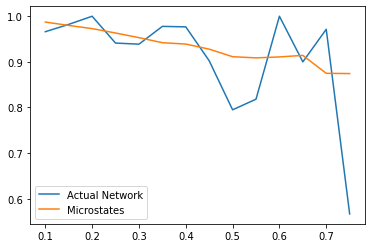

In [104]:
plot_lcc_sizes(moreno_train, random_attack)

We observe that both the original network as well as the microstates with the same degree sequence seem to be equally robust to random attacks.

LCC size of the original network: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]. Avg. LCC size of the Microstates: [0.9966666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].


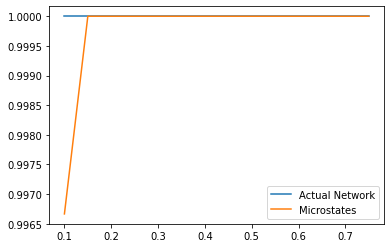

In [108]:

plot_lcc_sizes(moreno_train, targeted_attack)

Furthermore, the original network and the microstates seem to very robust to targeted attacks.

LCC size of the original network: [0.9464285714285714, 0.9622641509433962, 0.9607843137254902, 0.9583333333333334, 0.9130434782608695, 0.8571428571428571, 0.8837209302325582, 0.9767441860465116, 0.8974358974358975, 0.825, 0.5294117647058824, 0.918918918918919, 0.84375, 0.8571428571428571]. Avg. LCC size of the Microstates: [0.9811779448621553, 0.9670774410774411, 0.9676720965309198, 0.9561585228854227, 0.9433634065265162, 0.9409224536455048, 0.9257629455430244, 0.9185474814877149, 0.9101343397428875, 0.877730931652184, 0.84501999655771, 0.8489289343387607, 0.8432549596217577, 0.8477215043651269].


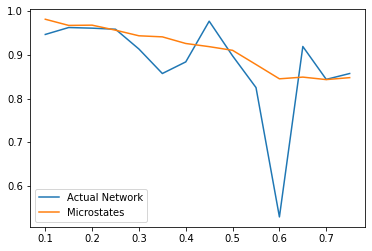

In [109]:
plot_lcc_sizes(dolphins, random_attack)

LCC size of the original network: [0.8333333333333334, 0.6666666666666666, 0.6666666666666666, 0.7333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]. Avg. LCC size of the Microstates: [0.8366666666666669, 0.9466666666666668, 0.9716666666666667, 0.9986666666666667, 0.9977777777777778, 0.999047619047619, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].


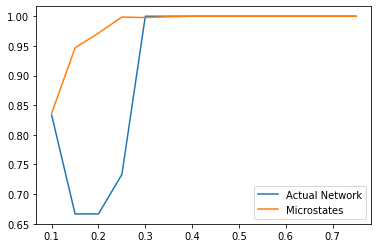

In [110]:

plot_lcc_sizes(dolphins, targeted_attack)

For the dolphins network, we make essentially the same observations as for the previous network.